# This Notebook uses Rotary indicTrans2 1B model for Machine Translation from English to Inidan Languages

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
pip install IndicTransToolkit

In [ ]:
pip install evaluate sacrebleu

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
import torch
import warnings
import json
from IndicTransToolkit.processor import IndicProcessor
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import evaluate

2025-08-28 05:25:47.970319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756358748.243513      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756358748.334051      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# languages not in flores_plus -> doi_Deva
# Inference issue with kas_Arab and kas_Deva
In_langs = ['asm_Beng','ben_Beng','brx_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','kas_Deva','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']

In [7]:
ds={}

In [ ]:
for lan in In_langs:
    ds[lan] = load_dataset("openlanguagedata/flores_plus",lan,split='dev',trust_remote_code=True)

In [ ]:
# ds['eng_Latn'] = load_dataset("openlanguagedata/flores_plus",'eng_Latn',split='dev',trust_remote_code=True)

In [ ]:
warnings.filterwarnings("ignore")
model_name = "prajdabre/rotary-indictrans2-en-indic-1B"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
ip = IndicProcessor(inference=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to(device)

In [8]:
translations = {}

In [ ]:
batch_size = 6

In [ ]:
def translate(sentences,src_lang, tgt_lang):
    translations[f"{src_lang}-{tgt_lang}"] = []
    with torch.inference_mode():
        for i in range(0, len(sentences),batch_size):
            batch = ip.preprocess_batch(sentences[i:i+batch_size], src_lang, tgt_lang)
            batch = tokenizer(batch, padding="longest", truncation=True, max_length=2048, return_tensors="pt").to(device)
            outputs = model.generate(
                **batch,
                num_beams=5,
                length_penalty=1.5,
                repetition_penalty=2.0,
                num_return_sequences=1,
                max_new_tokens=2048,
                early_stopping=True
            )

            outputs = tokenizer.batch_decode(
                outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            outputs = ip.postprocess_batch(outputs, lang = tgt_lang)
            print(f"Translations from {src_lang} to {tgt_lang}: Btach - {i/batch_size}")
            translations[f"{src_lang}-{tgt_lang}"] += outputs
            del batch, outputs
            torch.cuda.empty_cache()

In [ ]:
translate(sentences = ds['eng_Latn']['text'][320:340],src_lang = 'eng_Latn', tgt_lang = 'kas_Deva')


## Inferencing and Saving the output to a json file

In [ ]:
src_lang = 'eng_Latn'
for lang in In_langs:
    translate(sentences = ds[src_lang]['text'],src_lang = src_lang, tgt_lang = lang)
    try:
        with open("translations.json", "w", encoding="utf-8") as f:
            json.dump(translations, f, indent=4, ensure_ascii=False)
        print(f"File saved as of {lang}")
    except IOError as e:
        print(f"Error saving file: {e}")
        

In [ ]:
len(translations['eng_Latn-kas_Deva'])

## Loading the saved translations

In [9]:
with open('/kaggle/input/all-translations/f_translations.json','r',encoding='utf-8') as f:
    translations = json.load(f)

In [10]:
translations['eng_Latn-tam_Taml'][0]

'திங்களன்று, ஸ்டான்போர்ட் பல்கலைக்கழக மருத்துவப் பள்ளியின் விஞ்ஞானிகள் உயிரணுக்களை வகை வாரியாக வரிசைப்படுத்தக்கூடிய ஒரு புதிய நோயறிதல் கருவியைக் கண்டுபிடித்ததாக அறிவித்தனர்ஃ ஒரு சிறிய அச்சிடக்கூடிய சிப், இது நிலையான இன்க்ஜெட் அச்சுப்பொறிகளைப் பயன்படுத்தி தலா ஒரு அமெரிக்க சென்ட் வரை தயாரிக்கப்படலாம்.'

## Evaluating the Translations

In [11]:
avl_langs = ['asm_Beng','ben_Beng','brx_Deva','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']

In [12]:
evaluation_scores = {}

In [15]:
chrf = evaluate.load("chrf")

In [16]:
def reshape_to_2D(refs):
    return np.array(refs).reshape(-1,1)

In [17]:
for lang in avl_langs:
    preds = translations[f"eng_Latn-{lang}"]
    refs = ds[lang]['text']
    eval_score = chrf.compute(predictions = preds, references = reshape_to_2D(refs), word_order = 2)
    evaluation_scores[lang] = []
    evaluation_scores[lang] = eval_score['score']

In [19]:
evaluation_scores

{'asm_Beng': 40.14797970081293,
 'ben_Beng': 52.081167068162074,
 'brx_Deva': 40.364002246396026,
 'gom_Deva': 41.931595569141805,
 'guj_Gujr': 54.88892683345302,
 'hin_Deva': 59.81555697636743,
 'kan_Knda': 54.4540485478577,
 'mai_Deva': 49.07368251369397,
 'mal_Mlym': 55.602182061724456,
 'mar_Deva': 51.27640705251962,
 'mni_Beng': 38.647415680932184,
 'mni_Mtei': 45.13599203343371,
 'npi_Deva': 55.52912251467986,
 'ory_Orya': 49.572819731317374,
 'pan_Guru': 53.47150941271518,
 'san_Deva': 29.831543414175638,
 'sat_Olck': 32.34941777355764,
 'snd_Arab': 25.93464777615762,
 'snd_Deva': 38.94067817944221,
 'tam_Taml': 57.654315060639775,
 'tel_Telu': 57.42564131665782,
 'urd_Arab': 51.9947839790736}

## Visualizing the output

In [20]:
score = [val for val in evaluation_scores.values()]
score = reshape_to_2D(score)
score

array([[40.1479797 ],
       [52.08116707],
       [40.36400225],
       [41.93159557],
       [54.88892683],
       [59.81555698],
       [54.45404855],
       [49.07368251],
       [55.60218206],
       [51.27640705],
       [38.64741568],
       [45.13599203],
       [55.52912251],
       [49.57281973],
       [53.47150941],
       [29.83154341],
       [32.34941777],
       [25.93464778],
       [38.94067818],
       [57.65431506],
       [57.42564132],
       [51.99478398]])

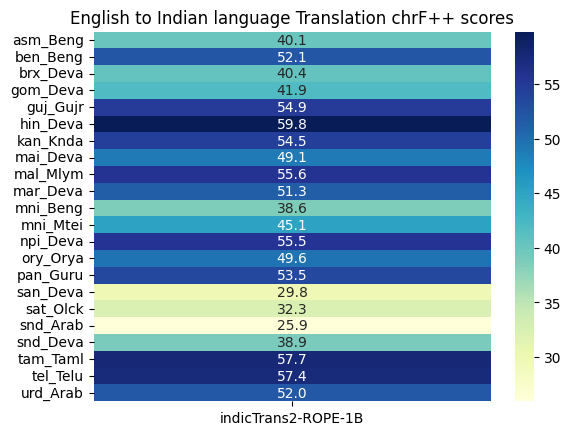

In [22]:
sns.heatmap(score,annot=True, fmt=".1f",xticklabels = ["indicTrans2-ROPE-1B"],yticklabels = evaluation_scores.keys(),cmap = 'YlGnBu')
plt.title("English to Indian language Translation chrF++ scores")
plt.show()